In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
import pyproj

In [2]:
data = "../ProjetoIntegrador1/Data/Real_State_Properati.csv"

data_Frame = pd.read_csv(data, sep = '\t')
print('rows',len(data_Frame))
print('columns',len(data_Frame.columns))
data_Frame

rows 17223
columns 9


,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0
2,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,138000.0,USD,45.0
3,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,195000.0,USD,65.0
4,PH,Mataderos,Argentina,Capital Federal,-34.652356,-58.501624,239000.0,USD,140.0
...,...,...,...,...,...,...,...,...,...
17218,apartment,Barrio Norte,Argentina,Capital Federal,-34.599214,-58.402519,165000.0,USD,91.0
17219,apartment,Recoleta,Argentina,Capital Federal,-34.587425,-58.397372,165000.0,USD,44.0
17220,apartment,Belgrano,Argentina,Capital Federal,-34.563685,-58.442683,410000.0,USD,157.0
17221,apartment,Belgrano,Argentina,Capital Federal,-34.563685,-58.442683,410000.0,USD,157.0


In [3]:
is_null_result = data_Frame.isnull()
quantidade_nulls = is_null_result.sum()
print(quantidade_nulls)

property_type          0
place_name             0
country_name           0
state_name             0
lat                    0
lon                    0
price                  0
currency               0
surface_total_in_m2    0
dtype: int64


In [4]:
data_Frame_USD = data_Frame[data_Frame.currency == 'USD']
len(data_Frame_USD)/len(data_Frame.index)*100

data_Frame_nUSD = data_Frame[data_Frame.currency != 'USD']
len(data_Frame_nUSD)/len(data_Frame.index)*100

3.0366370551007376

In [5]:
data_Frame_nUSD

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
58,apartment,Paternal,Argentina,Capital Federal,-34.603594,-58.465425,1099350.0,ARS,27.0
59,apartment,Paternal,Argentina,Capital Federal,-34.603594,-58.465425,1113420.0,ARS,27.0
60,apartment,Paternal,Argentina,Capital Federal,-34.603594,-58.465425,1127700.0,ARS,27.0
61,apartment,Paternal,Argentina,Capital Federal,-34.603594,-58.465425,1141980.0,ARS,27.0
62,apartment,Paternal,Argentina,Capital Federal,-34.603594,-58.465425,1327515.0,ARS,32.0
...,...,...,...,...,...,...,...,...,...
16977,apartment,Villa Urquiza,Argentina,Capital Federal,-34.573427,-58.473572,2337233.0,ARS,45.0
17021,apartment,Belgrano,Argentina,Capital Federal,-34.564408,-58.437251,650000.0,ARS,132.0
17113,apartment,Villa Crespo,Argentina,Capital Federal,-34.597679,-58.443019,2960000.0,ARS,53.0
17165,apartment,Coghlan,Argentina,Capital Federal,-34.558708,-58.486731,2651200.0,ARS,70.0


- Código de baixo é uma função para transformar a moeda ARS em USD

In [6]:
price_usd = round(data_Frame.apply(lambda x: x["price"] if x["currency"] == "USD" else x["price"]/117.41,axis=1),1)

In [7]:
print(type(price_usd))
print("Número de elementos em preco_m2: " + str(len(price_usd)))
print("Quantidade de linhas em data: " + str(data_Frame.shape[0]))

<class 'pandas.core.series.Series'>
Número de elementos em preco_m2: 17223
Quantidade de linhas em data: 17223


In [8]:
data_Frame.head(3)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0
2,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,138000.0,USD,45.0


In [9]:
data_Frame_nUSD.head(3)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
58,apartment,Paternal,Argentina,Capital Federal,-34.603594,-58.465425,1099350.0,ARS,27.0
59,apartment,Paternal,Argentina,Capital Federal,-34.603594,-58.465425,1113420.0,ARS,27.0
60,apartment,Paternal,Argentina,Capital Federal,-34.603594,-58.465425,1127700.0,ARS,27.0


- Código para criar uma coluna chama "preço em USD"

In [10]:
data_Frame["preço em USD"] = price_usd

In [11]:
dataARS = data_Frame[data_Frame.currency == "ARS"]

In [12]:
dataARS

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,preço em USD
58,apartment,Paternal,Argentina,Capital Federal,-34.603594,-58.465425,1099350.0,ARS,27.0,9363.3
59,apartment,Paternal,Argentina,Capital Federal,-34.603594,-58.465425,1113420.0,ARS,27.0,9483.2
60,apartment,Paternal,Argentina,Capital Federal,-34.603594,-58.465425,1127700.0,ARS,27.0,9604.8
61,apartment,Paternal,Argentina,Capital Federal,-34.603594,-58.465425,1141980.0,ARS,27.0,9726.4
62,apartment,Paternal,Argentina,Capital Federal,-34.603594,-58.465425,1327515.0,ARS,32.0,11306.7
...,...,...,...,...,...,...,...,...,...,...
16977,apartment,Villa Urquiza,Argentina,Capital Federal,-34.573427,-58.473572,2337233.0,ARS,45.0,19906.6
17021,apartment,Belgrano,Argentina,Capital Federal,-34.564408,-58.437251,650000.0,ARS,132.0,5536.2
17113,apartment,Villa Crespo,Argentina,Capital Federal,-34.597679,-58.443019,2960000.0,ARS,53.0,25210.8
17165,apartment,Coghlan,Argentina,Capital Federal,-34.558708,-58.486731,2651200.0,ARS,70.0,22580.7


In [13]:
data_Frame

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,preço em USD
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0,62000.0
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0,72000.0
2,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,138000.0,USD,45.0,138000.0
3,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,195000.0,USD,65.0,195000.0
4,PH,Mataderos,Argentina,Capital Federal,-34.652356,-58.501624,239000.0,USD,140.0,239000.0
...,...,...,...,...,...,...,...,...,...,...
17218,apartment,Barrio Norte,Argentina,Capital Federal,-34.599214,-58.402519,165000.0,USD,91.0,165000.0
17219,apartment,Recoleta,Argentina,Capital Federal,-34.587425,-58.397372,165000.0,USD,44.0,165000.0
17220,apartment,Belgrano,Argentina,Capital Federal,-34.563685,-58.442683,410000.0,USD,157.0,410000.0
17221,apartment,Belgrano,Argentina,Capital Federal,-34.563685,-58.442683,410000.0,USD,157.0,410000.0


- Depois que deixamos tudo em USD, dropamos a coluna "price" que está com a moeda ARS, dropamos também a coluna "currency" porque não precisa pois está todos os preços em USD, além também da coluna "state_name" pois todos os lugares estão no mesmo estado

In [25]:
Data = data_Frame.drop(["price","currency","state_name"],axis =1 )

In [26]:
Data

,property_type,place_name,country_name,lat,lon,surface_total_in_m2,preço em USD
0,PH,Mataderos,Argentina,-34.661824,-58.508839,55.0,62000.0
1,apartment,Mataderos,Argentina,-34.652262,-58.522982,55.0,72000.0
2,apartment,Belgrano,Argentina,-34.559873,-58.443362,45.0,138000.0
3,apartment,Belgrano,Argentina,-34.559873,-58.443362,65.0,195000.0
4,PH,Mataderos,Argentina,-34.652356,-58.501624,140.0,239000.0
...,...,...,...,...,...,...,...
17218,apartment,Barrio Norte,Argentina,-34.599214,-58.402519,91.0,165000.0
17219,apartment,Recoleta,Argentina,-34.587425,-58.397372,44.0,165000.0
17220,apartment,Belgrano,Argentina,-34.563685,-58.442683,157.0,410000.0
17221,apartment,Belgrano,Argentina,-34.563685,-58.442683,157.0,410000.0


In [24]:
a = Data[Data.state_name == "Capital Federal" ]
a.shape == Data.shape

True

In [16]:
bairros = Data["place_name"]
bairros.value_counts()

import shapely.wkt


In [17]:
shapely.wkt.loads

<function shapely.wkt.loads(data)>

In [18]:
Data.lat,Data.lon

(0       -34.661824
 1       -34.652262
 2       -34.559873
 3       -34.559873
 4       -34.652356
            ...    
 17218   -34.599214
 17219   -34.587425
 17220   -34.563685
 17221   -34.563685
 17222   -34.570639
 Name: lat, Length: 17223, dtype: float64,
 0       -58.508839
 1       -58.522982
 2       -58.443362
 3       -58.443362
 4       -58.501624
            ...    
 17218   -58.402519
 17219   -58.397372
 17220   -58.442683
 17221   -58.442683
 17222   -58.475596
 Name: lon, Length: 17223, dtype: float64)

In [20]:
type(bairros)

pandas.core.series.Series

<AxesSubplot:>

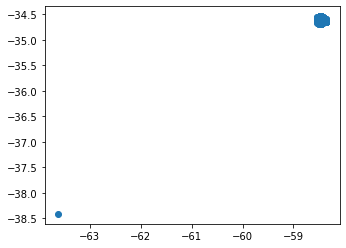

In [21]:
geometry = gpd.points_from_xy(Data.lon,Data.lat)
geo_Data = gpd.GeoDataFrame(Data,geometry = geometry)
geo_Data.plot()